### This file will use the Rotational Forest Classifier from the Aeon library

In [1]:
import _Data_Processing
from importlib import reload

'''
this function returns 7 objects:
	data: sets of data as X_train, X_val, X_ind, y_train, y_val, y_ind
	feature_list: list of all feature names with a column index (dict)
'''

reload(_Data_Processing)

lstm_format = False

X_train, X_val, X_ind,\
y_train, y_val, y_ind,\
feature_subsets =\
_Data_Processing.preprocess_data(
	file_name   =		'pricearea_c.csv'
	,indp_size  =		0.01
	,test_size  =		0.20
	,shfl_splt	=		False
	,t_start    =		570
	,t_end		=		645
	,mod_type	=		'Area_Classification'
	,target_t	=		30
	,num_class	=		2
	,split_val	=		5
	,verbose	=		1
	,scaler		=		'Standard'
	,frmt_lstm	=		lstm_format
	,time_steps =		5
	,keep_price =		False
)

Trying to load CSV file into DataFrame...Success.
Size of dataset:	1136505380
Size after reduction:	568252772
Trying to drop unused targets...Success.
Trying to collect indices of wanted times...Success.
Trying to drop price features...Success...

# of Samples:	226576

# of Features:	436

Target:		tc_2a_30m

Trying to split DataFrame into X and y...<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.float32'>
Success.
Trying to collect all feature names and indices...Success.
Trying to clean up...Success.
Trying to encode y and make class weights...Failed [NON-FATAL: NOT IMPLEMENTED]
Trying to standardize all featurespace from training featurespace...Success.
Trying to drop unwanted time-range samples...Success.
	214004 Samples Dropped.

Trying to split X and y into Train/Validation/Independent...Success.
Trying to clean up...Success.
X_train:	(9931, 436).
y_train:	(9931,).
X_val:  	(2515, 436).
y_val:  	(2515,).
X_ind:  	(126, 436).
y_ind:  	(126,).
Terminating.


In [2]:
import _Data_Rotating
from importlib import reload
'''
This function returns 4 items.
-	2D array of X partitions, by featurespace and samplespace
-	1D array of index-lists for each featurespace-partition specific features
-	1D array of featurespace-partition specific rotation transformer functions
-	1D array of y partitions for each samplespace partition.
'''

reload(_Data_Rotating)

X_train_parts, X_find_parts, X_trans_parts, y_parts = _Data_Rotating.rotate_partitions(
	X				=	X_train
    ,y				=	y_train
	,n_feat_parts	=	8
	,feat_subsets	=	feature_subsets
	,feat_part_type	=	'by_subset'
	,fraction_feats	=	0.90
	,no_feat_overlap=	False
	,feats_for_all	=	[]
	,rotation_type	=	'PCA'
	,rotation_filter=	False
	,filter_type	=	'Retention'
	,filter_value	=	1.0
    ,n_sample_parts	=	1
    ,smpl_part_type	=	'Even'
    ,sample_shuffle	=	False
    ,lstm_format	=	lstm_format
)

'''
all partitions
	X_train_parts
all sample partitions of THE featurespace partition i
	X_train_parts[i]
The single partition of THE samplespace partition j of THE featurespace partition i
	X_train_parts[i][j] -- -- -- This is now a set of trainable data
'''

'\nall partitions\n\tX_train_parts\nall sample partitions of THE featurespace partition i\n\tX_train_parts[i]\nThe single partition of THE samplespace partition j of THE featurespace partition i\n\tX_train_parts[i][j] -- -- -- This is now a set of trainable data\n'

In [3]:
import _Modelset_Training
reload(_Modelset_Training)

_Modelset_Training.show_available_model_types()

	   'decision_tree'
	   'dt'
		-	-	Sci-Kit Learn DecisionTreeClassifier
		-	-	{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1}
	   
	   'rotation_forest'
	   'aeon_rf'
		   -	-	AEON Rotation Forest
		-	-	{'base_estimator': DecisionTreeClassifier(max_depth=4), 'n_estimators': 4, 'min_group': 1, 'max_group': 20, 'remove_proportion': 0.3, 'n_jobs': -1}
	   
	   'continuous_interval_tree'
	   'cit'
	   -	-	Sci-Kit Learn ContinuousIntervalTreeVectorClassifier
	   -	-	{'max_depth': 4, 'thresholds': 20}
	   
	   


In [4]:
import _Modelset_Training
from importlib import reload

'''
Function returns a 3D list of trained models that are fit to the resepective dataset.
	Dim1:	Featurespace, here are the subsetctions/partitions for each unique set of features
    Dim2:	Samplespace, here are the subsetctions/partitions for each unique set of samples
    Dim3:	Modelspace, here are the individual models trained on a unique partition
'''
reload(_Modelset_Training)

models = _Modelset_Training.train_models(
    model_types	=	['dt']
    ,data_parts	=	X_train_parts
    ,trgt_parts	=	y_parts
    ,param_mode	=	'default'
    ,cst_mod_prm=	None
    ,tnr_verbose=	True
    ,lstm_frmt	=	lstm_format
    ,use_cls_wt	=	True
)

Default parameters selected.
dt	-	{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [5]:
import _Model_Evaluation

reload(_Model_Evaluation)

_Model_Evaluation.evaluate_models(
		models=models
		,X_findx=X_find_parts
		,X_trans=X_trans_parts
		,X_train=X_train_parts
		,y_train=y_parts
		,X_test=X_val
		,y_test=y_val
		,prfm_gnrl	=	'all'
		,prfm_stat	=	'all'
		,disp_mthd	=	'as_value'
		,test_whch	=	'independent'
		,pred_type	=	'classification'
        ,lstm_frmt	=	lstm_format
)

Dimensions of Trained Models:
	Feature Space: 8
	Sample Space: 1
	Model Space: 1


	Displaying all performances for all independent samples: (8 cases)

4

Statistics Overall:

	Split 0:
				Avg	St.Dv.	Low	High
		Accuracy	0.54	0.02	0.5	0.56
		Precision	0.57	0.01	0.55	0.59
		Recall		0.54	0.14	0.2	0.71

Statistics By Feature Space:

	Split 0:
				Avg	St.Dv.	Low	High
		Accuracy	0.5	0.0	0.5	0.5
		Precision	0.56	0.0	0.56	0.56
		Recall		0.2	0.0	0.2	0.2
	Split 1:
				Avg	St.Dv.	Low	High
		Accuracy	0.55	0.0	0.55	0.55
		Precision	0.56	0.0	0.56	0.56
		Recall		0.57	0.0	0.57	0.57
	Split 2:
				Avg	St.Dv.	Low	High
		Accuracy	0.55	0.0	0.55	0.55
		Precision	0.55	0.0	0.55	0.55
		Recall		0.71	0.0	0.71	0.71
	Split 3:
				Avg	St.Dv.	Low	High
		Accuracy	0.56	0.0	0.56	0.56
		Precision	0.58	0.0	0.58	0.58
		Recall		0.59	0.0	0.59	0.59
	Split 4:
				Avg	St.Dv.	Low	High
		Accuracy	0.55	0.0	0.55	0.55
		Precision	0.57	0.0	0.57	0.57
		Recall		0.59	0.0	0.59	0.59
	Split 5:
				Avg	St.Dv.	Low	High
		Accuracy	0.54	0.0	

/home/logankelsch/ES/-ES-NN-test1/.tf_/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Running on: GPU

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5289 - loss: 0.6954 - precision: 0.5371 - recall: 0.5220 - val_accuracy: 0.5149 - val_loss: 0.6871 - val_precision: 0.5396 - val_recall: 0.5396 - learning_rate: 0.0010
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5313 - loss: 0.6958 - precision: 0.5366 - recall: 0.5649 - val_accuracy: 0.5169 - val_loss: 0.6864 - val_precision: 0.5414 - val_recall: 0.5434 - learning_rate: 0.0010
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5442 - loss: 0.6886 - precision: 0.5677 - recall: 0.5646 - val_accuracy: 0.5149 - val_loss: 0.6860 - val_precision: 0.5412 - val_recall: 0.5208 - learning_rate: 0.0010
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5379 - loss: 0.6902 - precision: 0.5525 - recall: 0.5222 - val_accuracy: 0.5328 - val_loss: 0.6858 - val_precision: 0.5556 - val_recall: 0.5660 - learning_rate: 0.0010
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

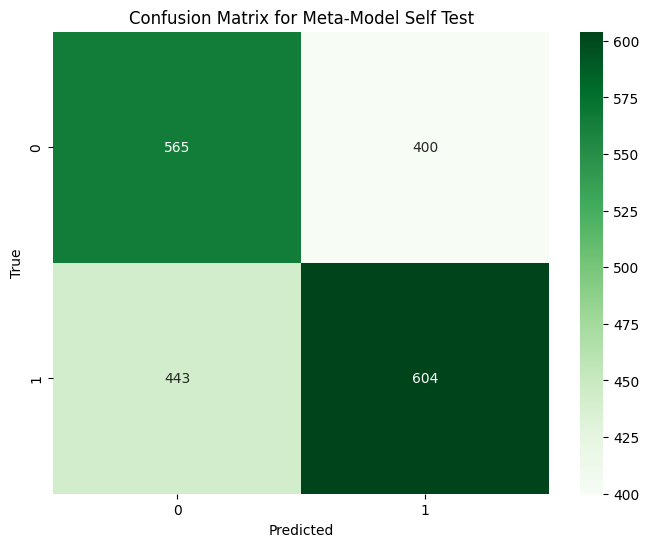

META-MODEL INDEPENDENT TEST:
	Accuracy:	0.58
	Precision:	0.61
	Recall:		0.58


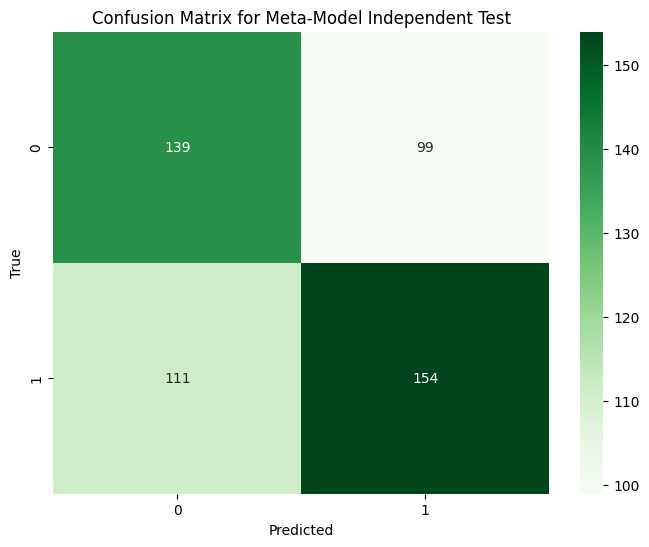

In [21]:
import _Metamodel
from importlib import reload

reload(_Metamodel)
metamodel, prediction_set = _Metamodel.train_test_meta_model(
	models	=	models
	,X_findx=X_find_parts
	,X_trans=X_trans_parts
	,X_test	=	X_val
	,y_test	=	y_val
	,val_size	=	0.2
	,shuffle	=	True
	,metam_type = 'NN'
    ,use_cls_wt = True
    ,use_mm_params=True
    ,metam_params={'LSTM':False,'epochs':100,'rlr_patience':250}
)

In [22]:
metamodel.save_as('_58percent_lost_tonotsavedmodelset_lol_1-18-25.keras')

In [ ]:
import numpy as np

zeros = np.array([])
for p in prediction_set:
    count = np.bincount(p)
    zeros = np.append(zeros, count[0])
    
y_val_zeros_indices = np.where(y_val != 0)[0]

zerocount_filtered = zeros[y_val_zeros_indices]
zerocount_filtered = zerocount_filtered.astype(int)

print((zerocount_filtered[0]))

frequenct_0 = np.array([])
frequenct_0 = np.bincount(zerocount_filtered)

print(frequenct_0)

import matplotlib.pyplot as plt

plt.bar(range(9),frequenct_0)

TypeError: Cannot cast array data from dtype('float32') to dtype('int64') according to the rule 'safe'

In [4]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

2025-01-18 23:19:04.872114: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-18 23:19:04.996419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737260345.046184  127460 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737260345.060938  127460 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-18 23:19:05.189252: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
